Explainer Notebook  
Project Title: The Spotify Artist Network  
By: Anders Nørskov and Terry Ho  
Contributions:
- Anders Nørskov: 
- Terry Ho:

# 1. Introduction

In [1]:
from functools import partial
from langid import langid
from konlpy.tag import Okt as Tag
from string import punctuation
from multiprocessing.pool import ThreadPool as Pool
from lyricsgenius import Genius
import regex as re
from tqdm import tqdm
from datetime import datetime
from time import sleep
from typing import Tuple
import tekore as tk
import urllib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from collections import defaultdict, Counter
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize #For languages that predominantly use spaces
from labMTsimple.storyLab import emotionFileReader
import networkx as nx
from networkx.algorithms.community.louvain import modularity, louvain_communities
import netwulf as nw
import random
import pickle as pkl

class Song:
    def __init__(self, ts, title, artists, id):
        self.title = title
        self.artists_raw = list(artists)
        self.artists = ", ".join(self.artists_raw)
        self.id = id
        self.ts = datetime.utcfromtimestamp(int(ts))
        self.a_n_t = f"{self.artists} - {self.title}"

    def __str__(self):
        return self.a_n_t

    def __repr__(self):
        return str(self)

    def __hash__(self):
        return hash(self.__repr__())

    def __eq__(self, other):
        return self.a_n_t.lower() == other.a_n_t.lower() or self.id == other.id
    
def song_from_track(t):
	return Song(0, t.name, map(lambda x: x.name, t.artists), t.id)

conf = tk.config_from_file("../tekore.conf", return_refresh=True)
client_id, client_secret, redirect_uri, user_refresh = conf
token = tk.refresh_user_token(client_id, client_secret, user_refresh)
sender = tk.RetryingSender(sender=tk.SyncSender())
spotify = tk.Spotify(token, sender=sender, max_limits_on=True, chunked_on=True)
current_user = spotify.current_user()

genius = Genius("KEFn0L8xkvDMGZive3aIXMuE6TB0aF2QwrWMDnhSdD_PEa9S_9129vPB38T-VKfb")
genius.verbose = False
genius.skip_non_songs = True

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Anders\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anders\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Motivation

## 2.1. Dataset

### 2.1.1. Spotify API

### 2.1.2. Everynoise.com

### 2.1.3. Genius API

## 2.2. Analysis and Goal
The goal of the end user's experience is to be able to find other artists based off of artists they listen to. While they can manually search up the artist to find related artists, the algorithm creates a network of artists based on every single artist they have in a playlist. By doing so, the user will have endless artists they can listen to that are similar to their music taste. 

Another goal is to group genres and artists based on sentiment. This allows the user to see the trends of each genre or artist. The resulting networks will be useful for a user who is a data analyst or even a casual listener who just wants to find music based on sentiment and emotion. 

# 3. Data Acquisition and Stats

This section will both include the methods of data acquisition and stats regarding the data in the order it is retrieved.

To see how all the data is acquired, in each step the artist "Taylor Swift" will be used to show outputs of each step.

## 3.1. Spotify + Everynoise.com Data

The first thing we want to acquire is general information about the artists on which we will be basing the analysis. Below is the code for acquiring the artists from the Spotify API directly and then for scraping the genres from Everynoise.com.

In [2]:
#Code to obtain HTML of a site.
def get_site(URL):
	#print("Loading...")
	html = ''
	try:
		html = urllib.request.urlopen(URL).read()
	except Exception as e:
		print("Unexpected Error: ", e, " with url: ", URL)
	#print("Done.")
	return html

#Code to obtain genres of the artist directly through the url.
def getGenresOfName(name: str):
	URL = f"http://everynoise.com/lookup.cgi?who={urllib.parse.quote(name)}"
	html = str(get_site(URL))
	genres = re.findall('t>([A-z0-9- ]*)<', html)
	return genres

try: #Load if not ran before
    with open('../data/artists.pkl', 'rb') as f:
        artists = pkl.load(f)
except:
    #Start off with some playlists.
    playlists = ["275YVJvF53dkyJtJLk9rfn","0qWfVDFyF0Tj7wjhxkN1kJ","2qJJIA8WyjzUwLkTlb0C0e", "0hYDNLOLfEnzOqzbM9Okj2"]
    songs = []
    for plst in playlists:
        songs += list(spotify.all_items(spotify.playlist(plst, market="from_token").tracks))
        
    artists = {}

    #Add the predetermined songs to the dictionary.
    for s in songs:
        for a in s.track.artists:
            artists[a.name] = {}
            artists[a.name]['id'] = a.id
            artists[a.name]['separation'] = 1
            artists[a.name]['genres'] = getGenresOfName(a.name)
            
    artists_checked = set()
    artist_related = defaultdict(lambda:[])

    #Step through each depth
    for i in range(3):
        next_degree_artists = []
        for a,data in tqdm(list(artists.items())):
            if data['id'] is None or data['id'] in artists_checked:
                continue
            try:
                for a2 in spotify.artist_related_artists(data['id']):
                    artist_related[a].append(a2.name)
                    if a2.id in artists_checked:
                        continue
                    artists[a2.name] = {}
                    artists[a2.name]['separation'] = artsts[a]['separation']+1
                    artists[a2.name]['genres'] = getGenresOfName(a2.name)
                    next_degree_artists.append(artists[a2.name])
            except KeyboardInterrupt:
                break
            except Exception as e:
                print("Fail on ", a, data['id'])
                print(e)
                continue
            artists_checked.add(data['id'])
            #sleep(0.1)
        artists.update(next_degree_artists)

To start off the data, some playlists are chosen as a starting point for the artists.
Since there is a rate limit of the Spotify API, the data will only be acquired to a depth of 3.
For each depth the above for loop goes through each artist and checks if they have been passed through the API.
If not, then the API is requested to retrieve all related artists.

Below shows the example of retrieving the related artists for "Taylor Swift":

She has ID: "06HL4z0CvFAxyc27GXpf02"

In [3]:
for i,a in enumerate(spotify.artist_related_artists(artists['Taylor Swift']['id'])):
    print(f"{i+1}.\t{a.name:<25}\twith ID {a.id}")

1.	Demi Lovato              	with ID 6S2OmqARrzebs0tKUEyXyp
2.	Alessia Cara             	with ID 2wUjUUtkb5lvLKcGKsKqsR
3.	Lorde                    	with ID 163tK9Wjr9P9DmM0AVK7lm
4.	Selena Gomez             	with ID 0C8ZW7ezQVs4URX5aX7Kqx
5.	Troye Sivan              	with ID 3WGpXCj9YhhfX11TToZcXP
6.	ZAYN                     	with ID 5ZsFI1h6hIdQRw2ti0hz81
7.	Miley Cyrus              	with ID 5YGY8feqx7naU7z4HrwZM6
8.	Fifth Harmony            	with ID 1l8Fu6IkuTP0U5QetQJ5Xt
9.	Niall Horan              	with ID 1Hsdzj7Dlq2I7tHP7501T4
10.	Harry Styles             	with ID 6KImCVD70vtIoJWnq6nGn3
11.	Carly Rae Jepsen         	with ID 6sFIWsNpZYqfjUpaCgueju
12.	Camila Cabello           	with ID 4nDoRrQiYLoBzwC5BhVJzF
13.	Jonas Brothers           	with ID 7gOdHgIoIKoe4i9Tta6qdD
14.	Julia Michaels           	with ID 0ZED1XzwlLHW4ZaG4lOT6m
15.	One Direction            	with ID 4AK6F7OLvEQ5QYCBNiQWHq
16.	Halsey                   	with ID 26VFTg2z8YR0cCuwLzESi2
17.	Meghan Trainor           	wit

These artists are thus added to the related artists of Taylor Swift and are further added to be searched next in the acquisition.

Note that Spotify has a related artists algorithm which will with the best of its ability try to retrieve 20 related artists of each artists. Which means we will generally have a branching factor of 20 in the graph. Some artists, however, are unknown, have corrupt metadata or have obscure origins and as such will therefore have less than 20 artists. But this is rare in the dataset.

Next, the genre is scraped from Everynoise.com. This is done simply by getting the HTML directly through the URL with the artist's name inserted as the %s search string. Regular Expressions is then used to extract the genres which are simply in a DIV inside the HTML.

An example of the genres returned for "Taylor Swift":

In [4]:
print(getGenresOfName("Taylor Swift"))

['pop']


Here Taylor Swift only has the single genre "pop" according to Everynoise.com. Another artist might have multiple genres, such as ["pop", "rock", "country"].

The size of the dataset after 3 passes is as follows:

There are 4425 unique genres.
There are  90815 artists.

The following genres are the most prevalent:
1.	pop            :	579 artists
2.	electro house  :	566 artists
3.	dance pop      :	563 artists
4.	edm            :	500 artists
5.	indie pop      :	489 artists
6.	hip hop        :	456 artists
7.	rock           :	455 artists
8.	pop rap        :	451 artists
9.	electropop     :	450 artists
10.	modern rock    :	440 artists


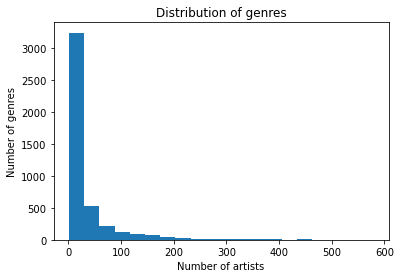

In [5]:
genres = set(g for _,data in artists.items() for g in data['genres'])
genre_prevalence = Counter()
for a,data in artists.items():
    for g in data['genres']:
        genre_prevalence[g] += 1

print("There are", len(genres), "unique genres.")
print("There are ", len(artists), "artists.")
print()
print("The following genres are the most prevalent:")
for i, (g, num) in enumerate(genre_prevalence.most_common(10)):
    print(f"{i+1}.\t{g:<15}:\t{num} artists")

plt.hist(list(genre_prevalence.values()), bins=20)
plt.xlabel("Number of artists")
plt.ylabel("Number of genres")
plt.title("Distribution of genres")
plt.show()

The last plot shows the distribution of artists over genres. As seen, most genres are quite small (less than 20 artists). Note: an artist can have multiple genres assigned, which means lesser known genres can still appear even though the artist has an overarching genre.

Also, remarkably, after only three passes there are already 90.8k artists in the dataset.

## 3.2. Genius Lyrics Data

The next thing to gather is the lyrics of the songs of the artists. At first we wanted to retrieve multiple songs from each artist, but due to time limits, the rate limit and the size of the data (1.2 GB for 1 song for 90.8k artists) we ended up only retrieving the first song.

The Spotify API can be used to retrieve the top songs of an artist. As such, the top song for each artist was retrieved. The Genius API can be used to search for lyrics by song title and artist.

Below is the code for retrieving the top artsts and the lyrics from Genius API for each artist in the dataset:

In [6]:
#Spotify API returns top 10 (or less) songs of an artist by current popularity
def getTop10Tracks(artist_id: str):
    return [song_from_track(t) for t in spotify.artist_top_tracks(artist_id, "US")]

#Query the Genius API for the lyrics of an artist's top songs.
#Returns a list of Genius Metadata for the songs.
#If failure to retreive, returns "FAILED"
#If lyrics not found or the song does not have lyrics, returns None.
def getTopNLyrics(artist_info: Tuple[str, str], n: int = 10):
    artist_name, artist_id = artist_info
    lyrics = []
    for song in getTop10Tracks(artist_id)[:n]:
        try:
            song_lyrics = genius.search_song(song.title, artist_name, get_full_info=False)
            sleep(0.5)
            lyrics.append((artist_name, artist_id, song, song_lyrics))
        except Exception as e:
            sleep(2.0)
            lyrics.append((artist_name, artist_id, song, "FAILED"))
            print(e)
    return lyrics

NUM_TOP_SONGS = 1

try:
    with open(f"../data/lyrics_cache_top{NUM_TOP_SONGS}.pkl", "rb") as f:
        lyrics_cache = pkl.load(f)
except:
    with tqdm(total=len(artists)) as pbar:
        for i in range(0, len(artists), 1000):
            #Multiprocessing to speed up the process of retrieval.
            with Pool(processes=12) as pool:
                lyrics_cache.extend(pool.map(partial(getTopNLyrics, n=NUM_TOP_SONGS), [(name, data["id"]) for name, data in list(artists.items())[i:i+1000]]))
                pbar.update(1000)
                with open(f"lyrics_cache_top{NUM_TOP_SONGS}.pkl", "wb") as f:
                    pkl.dump(lyrics_cache, f)

Above are the two functions needed to retrieve the lyrics. First the top songs which are directly retrieved from the Spotify API. The second function is used to search for lyrics by song title and artist on Genius. Finally, the process is sped up using multiprocessing while still waiting when the rate limit is reached (sleep in second function).

Note on the top songs: The songs are sorted by Spotify's own algorithmic popularity, which is not only based on the total number of plays of a song but also based on the current monthly listeners (and there might be other factors as well, i.e. featured songs, etc.).

Below are the lyrics to the top song for "Taylor Swift":

In [7]:
taylor_song = getTop10Tracks(artists['Taylor Swift']['id'])[0]
print("Taylor Swift's Top Song:")
print(taylor_song)
print()
taylor_genius = getTopNLyrics(('Taylor Swift',artists['Taylor Swift']['id']), 1)[0][-1]
taylor_lyrics = taylor_genius.lyrics
print("With the raw unfiltered/uncleaned lyrics:")
print()
print(taylor_lyrics)

Taylor Swift's Top Song:
Taylor Swift - All Too Well (10 Minute Version) (Taylor's Version) (From The Vault)

With the raw unfiltered/uncleaned lyrics:

All Too Well (10 Minute Version) (Taylor’s Version) [From the Vault] Lyrics[Verse 1]
I walked through the door with you, the air was cold
But somethin' 'bout it felt like home somehow
And I left my scarf there at your sister's house
And you've still got it in your drawer, even now

[Verse 2]
Oh, your sweet disposition and my wide-eyed gaze
We're singin' in the car, getting lost upstate
Autumn leaves fallin' down like pieces into place
And I can picture it after all these days

[Pre-Chorus]
And I know it's long gone and
That magic's not here no more
And I might be okay, but I'm not fine at all
Oh, oh, oh
[Chorus]
'Causе there we arе again on that little town street
You almost ran the red 'cause you were lookin' over at me
Wind in my hair, I was there
I remember it all too well

[Verse 3]
Photo album on the counter, your cheeks were turn

As seen, the song is quite abnormally long (10 minutes) and as such the lyrics are quite long, too. Also note how the lyrics begin with the title of the song and then " Lyrics" and it ends with "199Embed". These are just artifacts of the Genius API metadata embedded into the lyrics.
These will be cleaned up in the next step where the lyrics are tokenized.

## 3.3. Tokenization and Sentiment Scores
The next step consists of four parts:

    1. Detecting the language of the lyrics
    2. Pre-processing the lyrics
    3. Tokenizing the lyrics
    4. Getting the LabMT sentiment values

In [8]:
get_sentiments = False
try:
    df = pd.read_pickle("../data/lyrics_sentiment.pkl")
except:
    get_sentiments = True

#Available languages: English, French, German, Hindi, Indonesian, Korean, Portuguese, Russian, Spanish.
languages = ['english','french','german','hindi','indonesian','korean','portuguese','russian','spanish']
languages_short = set(['en', 'fr', 'de', 'hi', 'id', 'ko', 'pt', 'ru', 'es'])

#Make a combined dictionary of sentiment scores
token_sentiment = {}
for lang in languages:
    _, vector, words = emotionFileReader(stopval=0.0,lang=lang, returnVector=True)
    for word, value in zip(words,vector):
        token_sentiment[word.lower()] = value

#Language detection
lang_classify = langid.LanguageIdentifier.from_modelstring(langid.model, norm_probs=True).classify
#Translation table to remove punctuation
table = str.maketrans('', '', punctuation)

if get_sentiments:
    #Korean tokenizer
    konlpy_tokenize = partial(Tag().morphs,norm=True)
    
    df = pd.DataFrame(columns=['artist_id','artist_name','song_id','song_name','lyric_tokens','sentiment','language'])

    missing_lyrics = set()
    with tqdm(total=len(lyrics_cache)) as pbar:
        while len(lyrics_cache) > 0:
            song_data = lyrics_cache.pop()
            pbar.update(1)
            for artist_name, artist_id, song, lyric in song_data:
                if lyric is None or lyric == "FAILED" or len(lyric.lyrics) > 10000:
                    missing_lyrics.add(artist_id)
                    continue
                #Get lyrics raw text
                lyric_text = lyric.lyrics
                
                #Clean up genius annotations
                genius_intro = lyric.title+" Lyrics"
                if lyric_text.startswith(genius_intro):
                    lyric_text = lyric_text[len(genius_intro):]
                if lyric_text.endswith("Embed"):
                    lyric_text = lyric_text[:-5]
                
                #Detect language
                language_family, prob = lang_classify(lyric_text) #Step 1.
                # Select tokenizer based on language
                if not language_family in languages_short or prob < 0.5: #Step 2.
                    continue #Skip if unknown language or low confidence
                elif language_family == 'ko':
                    tokenize_func = konlpy_tokenize
                else:
                    tokenize_func = word_tokenize
                
                #Clean up lyrics
                lyric_text = lyric_text.translate(table).lower() #Remove punctuation
                
                tokens = [] #Tokens for this lyric
                sentiment = [] #Sentiment for each token
                has_sentiment = [] #Whether or not the token has sentiment score in LabMT
                for tok in tokenize_func(lyric_text): #Step 3.
                    tokens.append(tok)
                    sentiment.append(token_sentiment.get(tok, 5)-5) #-5 to center LabMT sentiment scores around 0, Step 4.
                    has_sentiment.append(tok in token_sentiment)
                df = df.append({'artist_id':artist_id,
                                'artist_name':artist_name,
                                'song_id':song.id,
                                'song_name':song.title,
                                'lyric_tokens':tokens,
                                'sentiment':sentiment,
                                'has_sentiment':has_sentiment,
                                'language':language_family},
                            ignore_index=True)

Before anything else, the aforementioned metadata artifacts are removed from the lyrics. 

Then using the Lang Id Clasifier [1] the language of the lyrics is determined. If the language could not be detected (the model was uncertain about the primary language), or if it primarily contains a language not supported by the LabMT sentiment scoring [2] [3], then the artist/song is skipped.

The tokenizer is chosen based on the language detected. If the language is Korean, then a tokenizer from KoNLPy [4] is used. The specific tokenizer is the Open Korean Text by Will Hohyon Ryu [5]. This tokenizer provides Korean segmentation, normalization and stemming so that the segmented tokens can be looked up in the LabMT Korean sentiment dictionary. Otherwise, the NLTK word tokenizer [6] is used.

After a tokenizer is chosen the lyrics are cleaned up for punctuation and converted to lower-case.

After pre-processing, the lyrics are tokenized using the respective tokenizer and the tokens and their sentimental values are saved to the dataframe.

Note: Due to some dirty crowdsourced data, lyrics with more than 10,000 characters are skipped to avoid spam or other unwanted data.

Here are examples of all steps applied to the lyrics of the top song of "Taylor Swift":

In [9]:
genius_intro = taylor_genius.title+" Lyrics"

if taylor_lyrics.startswith(genius_intro):
    taylor_lyrics = taylor_lyrics[len(genius_intro):]
if taylor_lyrics.endswith("Embed"):
    taylor_lyrics = taylor_lyrics[:-5]
    
print("Cleaned genius artifacts, here the first 200 characters of the lyrics:")
print()
print(taylor_lyrics[:200])
print("Note the title is now removed in the beginning.")
print("-----------------------------------------------------------")
taylor_lyrics = taylor_lyrics.translate(table).lower()
print("Cleaned up punctuation and lower case, here the first 200 characters of the lyrics:")
print()
print(taylor_lyrics[:200])
print()
taylor_tokens = [tok for tok in word_tokenize(taylor_lyrics)]
taylor_sentiments = [token_sentiment.get(tok, 5)-5 for tok in taylor_tokens]
taylor_mean_sentiment = np.mean(taylor_sentiments)
taylor_mean_emotion = np.mean(np.abs(taylor_sentiments))
print("Here are the first 15 tokens of the cleaned lyrics:")
print(" | ".join([f"{tok:^7}" for tok in taylor_tokens[:13]]))
print(" | ".join([f"{sen:^7.4g}" for sen in taylor_sentiments[:13]]))
print()
taylor_language,taylor_language_prob = lang_classify(taylor_lyrics)
print(f"Taylor Swift's language is '{taylor_language}' with probability {taylor_language_prob}")
print(f"Taylor Swift's mean sentiment (over the whole song) is {taylor_mean_sentiment:.4g}")
print(f"Taylor Swift's mean emotion (over the whole song) is {taylor_mean_emotion:.4g}")

Cleaned genius artifacts, here the first 200 characters of the lyrics:

[Verse 1]
I walked through the door with you, the air was cold
But somethin' 'bout it felt like home somehow
And I left my scarf there at your sister's house
And you've still got it in your drawer, ev
Note the title is now removed in the beginning.
-----------------------------------------------------------
Cleaned up punctuation and lower case, here the first 200 characters of the lyrics:

verse 1
i walked through the door with you the air was cold
but somethin bout it felt like home somehow
and i left my scarf there at your sisters house
and youve still got it in your drawer even now



Here are the first 15 tokens of the cleaned lyrics:
 verse  |    1    |    i    | walked  | through |   the   |  door   |  with   |   you   |   the   |   air   |   was   |  cold  
 0.84   |    0    |  0.12   |    1    |   0.2   |   0.2   |  -0.68  |  0.94   |  1.58   |   0.2   |  1.62   |  -0.16  |  -0.54 

Taylor Swift's language

As shown, the language was detected as English with 100% certainty, and her lyrics are generally emotional and with a positive sentiment.

Note that "verse" has a positive sentiment, even though it is not directly part of the lyrics and is a meta-part of the lyrics representation. This will be fixed later when the sentiment analysis is performed by removing meta-parts.

Below are the number of songs for each language:

In [10]:
print(df.groupby(['language']).count()['has_sentiment'])

language
de     1133
en    38496
es     1929
fr     1068
hi       12
id      147
ko      664
pt     1084
ru      299
Name: has_sentiment, dtype: int64


Below is the distribution of lyric lengths:

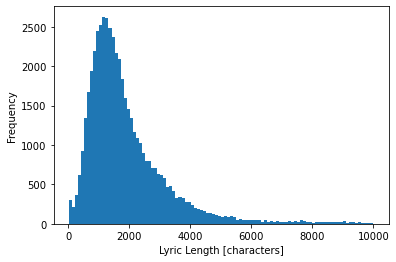

In [11]:
lyric_lengths = Counter()
for song_data in lyrics_cache:
    for artist_name, artist_id, song, lyric in song_data:
        if lyric is not None and lyric != "FAILED" and len(lyric.lyrics) < 10000:
            lyric_lengths[lyric] = len(lyric.lyrics)
plt.hist(lyric_lengths.values(), bins=100)
plt.xlabel("Lyric Length [characters]")
plt.ylabel("Frequency")
plt.show()

The mean length of lyrics seems to be around 1600 characters.

# 4. Tools, Theory and Analysis

## 4.1. The Spotify Network

With the data in place, it is now possible to create the Spotify Network based on the related artists. This will be done using Networkx and displayed using Netwulf.

The below code creates the graph:

In [19]:
# Create a graph
MG = nx.MultiGraph()
for name, data in artists.items():
    related_artists = data['related']
    genres = data['genres']
    MG.add_node(name, genres=genres, id=data['id'])

for name, data in artists.items():
    related_artists = data['related']
    for i,related_artist in enumerate(related_artists):
        MG.add_edge(name, related_artist,weight=1-i/len(related_artists))
        
#Remove isolated nodes
MG.remove_nodes_from(list(nx.isolates(MG)))
G = nx.Graph(MG)
#Merge over parallel edges averaging the weights
for u in MG.nodes:
    for v in MG.neighbors(u):
        if u == v:
            continue
        weight = 0
        n = 0
        for _, w in MG[u][v].items():
            weight += w['weight']
            n += 1
        G[u][v]['weight'] = weight/n
del MG

The graph is, to begin with, a MultiGraph meaning that multiple edges can be created between the same two artists.
First it iterates through each artist and creates a node containing the artist ID and genres.
Then an edge is created between each artist and its related artists. The edge weight is the inverse proportion of the ranking of the related artists, i.e. with 20 related artists, top 1 related artist has an edge weight of 1, top 2 has an edge weight of 0.95, etc. This is a simple linear weighting based on importance of the related artists, since the actual Spotify related artists algorithm values are not available.  Next, isolated parts of the graph are removed and the graph is converted to a single-edge graph by averaging the parallel edge weights.

The network is too large for this notebook, so it is only available on the website or through following the link below:
# NETWORK SVG LINK

Here, the colors of the nodes are based on the genre of the artist. For artists with multiple genres, the most common genre is used.

In [26]:
genre_commonality = Counter() #Used for finding the most common genre
artist_degrees_dist = Counter()
for artist_name, data in artists.items():
    for genre in data['genres']:
        genre_commonality[genre] += 1
genre_artists = defaultdict(set)
for artist_name, data in artists.items():
    if len(data['genres']) > 0:
        data['most_common_genre'] = max(data['genres'], key=genre_commonality.get)
    else:
        data['most_common_genre'] = 'None'
    if artist_name in G:
        genre_artists[data['most_common_genre']].add(artist_name)
        
genre_partition = list(genre_artists.values())

For comparison, the Louvain Community Detection Algorithm [7] is used to detect communities in the network. These communities will, of course, be very different from the ones based on genre alone since artists can have multiple genres.

The Louvain Community Detection Algorithm uses modularity to determine the communities. Modularity is a measure of the amount of information that is shared by the communities. Non-weighted modularity is the fraction of the number of edges linking members of the same community minus this fraction but if the network was randomly distributed. In simpler terms, it is the difference in density between the current community and if the edges were random and not based on a community. As such, this measure will upweigh communities/partitions which are more dense than expected from the random network. The weighted modularity is a bit more abstract, but it now considers the weight of the edges in the community, meaning more related artists (larger edge weights) will provide a larger weight on the modularity.

The Louvain Community Detection Algorithm is similar to the K-Means Clustering Algorithm, in that it is an iterative method which slowly builds up clusters/partitions of the network. In the first step, all nodes are assigned their own community. Then it tries to merge these nodes while noting the increase in modularity. This is then iteratively performed until the clusters/partitions are stable, i.e. the gain in modularity is miniscule. Then in the next step, the formed communities are merged to create new nodes and the first step is repeated.

In [27]:
louvain_partition = louvain_communities(G)
louvain_mod = modularity(G,louvain_partition)
genre_mod = modularity(G,genre_partition)
print(f"Louvain communities: {len(louvain_partition)}")
print(f"Louvain modularity: {louvain_mod:.4g}")
print(f"Genre communities: {len(genre_partition)}")
print(f"Genre modularity: {genre_mod:.4g}")

Louvain communities: 95
Louvain modularity: 0.8822
Genre communities: 3260
Genre modularity: 0.4161


It is hard to compare these values, since the genre partition is very fragmented by smaller artists/genres - and it is hard to consider if the genre partition matches one of the levels in the dendrogram formed by each step in the Louvain algorithm, and the Louvain algorithm, therefore, detects larger more over-arching genres than the specific Everynoise.com-assigned genres.

The network is, again, too large for this notebook, so it is only available on the website or through following the link below:
# NETWORK SVG LINK

Nevertheless, to determine if both of these modularities are significant from a random network, 1000 random networks based on the same graph is created. All of these random networks will keep the same degrees of the nodes, but the edges will be randomly redirected. This is done by simply getting all stubs and reordering them at random. Of note is, that in the original graph, there are no parallel edges or self-loops since artists are not related to themselves and the parallel edges are already merged. The random networks are expected to contain self-loops and parallel edges, but due to the size of the network, the number of self-loops and parallel edges is not expected to be large or significant.

Below is the code for the creation of the random networks:

In [ ]:
def random_network(G):
    #Copy graph: (MultiGraph because self-loops are allowed and parallel edges are allowed)
    G_c = nx.MultiGraph(G)
    #Create lists of source and target nodes:
    sources, targets = zip(*G.edges)
    #Concatenate sources and targets into a unique list:
    stubs = list(sources) + list(targets)
    #Shuffle the list of stubs:
    random.shuffle(stubs)
    #Build a set of edges (tuples) by connecting each element in the list of shuffled stubs with the following element:
    edges = [(stubs[i], stubs[i+1]) for i in range(0,len(stubs)-1,2)]
    #Remove all the original network edges from your network:
    G_c.remove_edges_from(G.edges)
    #Add all the new shuffled edges you created in step d:
    G_c.add_edges_from(edges)
    return G_c

1000 random networks are created for both the Louvain partition and the genre partition.

In [29]:
louvain_modularities = []
genre_modularities = []
try:
    with open('../data/louvain_random_modularities.pkl', 'rb') as f:
        louvain_modularities = pkl.load(f)
    with open('../data/genre_random_modularities.pkl', 'rb') as f:
        genre_modularities = pkl.load(f)
except:
    for _ in tqdm(range(1000)):
        random_net = random_network(G)
        louvain_modularities.append(modularity(random_net, louvain_partition))
        genre_modularities.append(modularity(random_net, genre_partition))

The modularities are then calculated for both the Louvain partition and the genre partition in the above code and the results are displayed below:

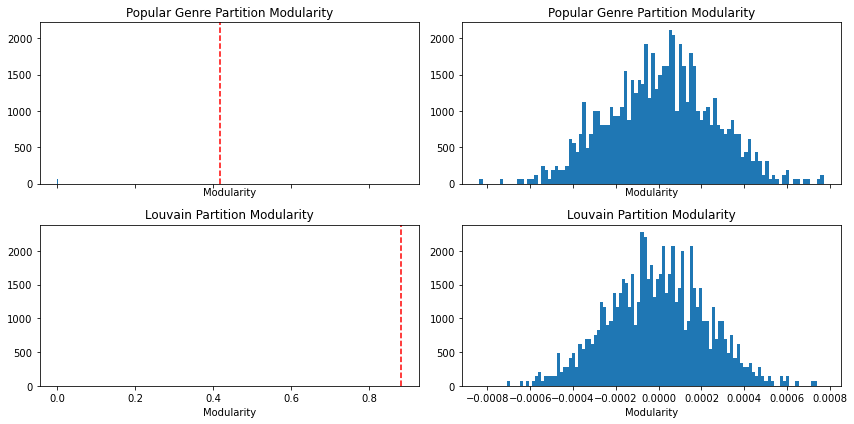

In [33]:
fig, axs = plt.subplots(2,2, figsize=(12,6), sharex='col')
axs[0,0].hist(genre_modularities, bins=100, density=True)
axs[0,0].axvline(x=genre_mod, color='r', linestyle='--')
axs[0,0].set_title('Popular Genre Partition Modularity')
axs[0,0].set_xlabel('Modularity')
axs[1,0].hist(louvain_modularities, bins=100, density=True)
axs[1,0].axvline(x=louvain_mod, color='r', linestyle='--')
axs[1,0].set_title('Louvain Partition Modularity')
axs[1,0].set_xlabel('Modularity')
axs[0,1].hist(genre_modularities, bins=100, density=True)
axs[0,1].set_title('Popular Genre Partition Modularity')
axs[0,1].set_xlabel('Modularity')
axs[1,1].hist(louvain_modularities, bins=100, density=True)
axs[1,1].set_title('Louvain Partition Modularity')
axs[1,1].set_xlabel('Modularity')
plt.tight_layout()

The plots to the right are the zoomed-in versions of the distribution in the left plots.
As seen, the modularities are very significant from the random networks. The narrow distribution of the modularities might be due to the fact that each artist has (in most cases) exactly 20 related artists, therefore, the random networks are more likely to be less dense in communities than the original network.

## 4.2. Sentiment Analysis

For sentiment analysis we will be performing both a moving average sentiment over a song progression (through lyrics) and furthermore simply assigning a sentiment value to each artist based on their song such that this can be used in later analysis, e.g. on the Spotify Network graph of artists.

The sentiment values were previously calculated in the acquisition step. Therefore, it is easy to retrieve these values and perform the moving average and the sentiment analysis.

The following code contains two functions:
1. Moving average sentiment over a song progression
2. Average over predefined buckets of the song progression

We will be using the LabMT sentiment scoring [2] [3] to assign a sentiment value to each artist. Two values will be calculated: the standard positive/negative sentiment and the absolute sentiment which we will be referring to as the emotion of a token/song.

In [12]:
def getSlidingWindowSentiment(sentiment, window_size=30):
    """
    Calculate the moving average of the sentiment over the window_size
    """
    return np.convolve(sentiment, np.ones(window_size)/window_size, mode='valid')

def normalizeProgression(slided_sentiment, buckets=100):
    """
    Convert the x-axis into buckets and average over the y-values in these buckets
    This is to normalize all song-lyrics to the same format
    Side effects: Long songs will be squeezed a lot.
    """
    bucket_size = int(len(slided_sentiment) / buckets)
    bucketed_sentiment = []
    for i in range(buckets):
        bucketed_sentiment.append(np.mean(slided_sentiment[i*bucket_size:(i+1)*bucket_size]))
    return bucketed_sentiment

The reason for these functions is to create a way to compare sentiment change over time for different genres and artists. The moving average smoothes the sentiment values since the lyrics will contain tokens which have zero sentiment value, and thus provide no information. The moving average will, therefore, better model the general sentiment progression of the song. Finally, the bucketing allows to squish the progression into a constant number of buckets each containing an average sentiment value. This will, of course, have consequences for longer songs since these will be squeezed a lot more and, therefore, show warped or very different sentiment progressions. Larger parts of the song will be averaged over compared to the moving average. In the analysis we will be using 100 buckets such that a single bucket corresponds to the sentiment of 1% of the tokens.

Below is the moving average sentiment and the bucketed sentiment of the top song of "Taylor Swift":

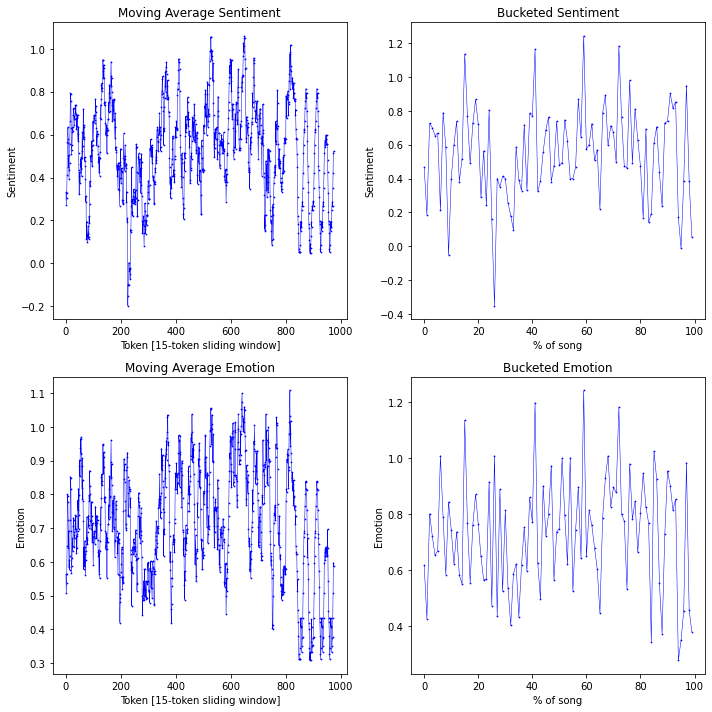

In [13]:
taylor_ma = getSlidingWindowSentiment(taylor_sentiments, window_size=15)
taylor_bu = normalizeProgression(taylor_sentiments, buckets=100)
taylor_ma_emo = getSlidingWindowSentiment(np.abs(taylor_sentiments), window_size=15)
taylor_bu_emo = normalizeProgression(np.abs(taylor_sentiments), buckets=100)
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0,0].plot(taylor_ma, marker='.', linestyle='-', color='b', lw=0.5, markersize=1.5)
axs[0,0].set_title("Moving Average Sentiment")
axs[0,0].set_xlabel("Token [15-token sliding window]")
axs[0,0].set_ylabel("Sentiment")
axs[0,1].plot(taylor_bu, marker='.', linestyle='-', color='b', lw=0.5, markersize=1.5)
axs[0,1].set_title("Bucketed Sentiment")
axs[0,1].set_xlabel("% of song")
axs[0,1].set_ylabel("Sentiment")
axs[1,0].plot(taylor_ma_emo, marker='.', linestyle='-', color='b', lw=0.5, markersize=1.5)
axs[1,0].set_title("Moving Average Emotion")
axs[1,0].set_xlabel("Token [15-token sliding window]")
axs[1,0].set_ylabel("Emotion")
axs[1,1].plot(taylor_bu_emo, marker='.', linestyle='-', color='b', lw=0.5, markersize=1.5)
axs[1,1].set_title("Bucketed Emotion")
axs[1,1].set_xlabel("% of song")
axs[1,1].set_ylabel("Emotion")
plt.tight_layout()
plt.show()

The example of using Taylor Swift's top song shows the disadvantage of using the moving average and bucketed sentiments since the song is so long that the moving average window is not large enough and the bucketed sentiment is not really representative of the song. Nevertheless, these progressions are still useful for the analysis. For example, the outro really stands out in the moving average with switching sentiment values in a repeated verse. Also, there seems to be large dip around token 200 but other than that, the song is generally positive in sentiment. Everything else is very noisy and hard to interpret, but patterns may still arise when this data is summarized over a whole genre.

The two aforementioned functions are used in the following code to calculate the sentiment progressions for all artists in the dataset. Bucket size is set to 100 to achieve the % of tokens in each bucket. The window size for the moving average is based on the average sentence length which is generally around 20-30 tokens in books/literature. For lyrics, this value should definitely be lower, so a window size of 15 is used, although this might span a whole verse at once for some songs.

In [14]:
WINDOW_SIZE = 15
BUCKETS = 100

genre_normalized_sentiment = defaultdict(list)
genre_normalized_emotion = defaultdict(list)
genre_mean_sentiment = defaultdict(list)
genre_mean_emotion = defaultdict(list)
genre_num_songs = Counter()
artist_emotion = Counter()
artist_sentiment = Counter()

total_sum_sentiment = 0
total_sum_emotion = 0
total_num_toks = 0
for artist_name, sentiment, has_sentiment in tqdm(zip(df["artist_name"],df["sentiment"], df["has_sentiment"]), total=len(df)):
    if len(sentiment) < BUCKETS + WINDOW_SIZE:
        continue
    sentiment = np.array(sentiment)
    mean_emotion = np.mean(np.abs(sentiment))
    mean_sentiment = np.mean(sentiment)
    total_sum_sentiment += np.sum(sentiment)
    total_sum_emotion += np.sum(np.abs(sentiment))
    total_num_toks += len(sentiment)
    artist_emotion[artist_name] = np.mean([np.abs(s) for s, h in zip(sentiment, has_sentiment) if h])
    artist_sentiment[artist_name] = np.mean([s for s, h in zip(sentiment, has_sentiment) if h])
    genres = artists[artist_name]['genres']
    slided_sentiment = getSlidingWindowSentiment(sentiment, WINDOW_SIZE)
    normalized_slided_sentiment = normalizeProgression(sentiment, BUCKETS)
    slided_emotion = getSlidingWindowSentiment(np.abs(sentiment), WINDOW_SIZE)
    normalized_slided_emotion = normalizeProgression(np.abs(sentiment), BUCKETS)
    for genre in genres:
        genre_mean_emotion[genre].append(mean_emotion)
        genre_mean_sentiment[genre].append(mean_sentiment)
        #genre_sliding_sentiment[genre].append(slided_sentiment)
        genre_normalized_sentiment[genre].append(normalized_slided_sentiment)
        genre_normalized_emotion[genre].append(normalized_slided_emotion)
        genre_num_songs[genre] += 1
mean_sentiment = total_sum_sentiment / total_num_toks
mean_emotion = total_sum_emotion / total_num_toks

100%|██████████| 44832/44832 [01:26<00:00, 516.36it/s]


The mean sentiment and emotion can then be calculated:

In [15]:
print(f"Mean Sentiment: {mean_sentiment:.4g}")
print(f"Mean Emotion: {mean_emotion:.4g}")

Mean Sentiment: 0.4809
Mean Emotion: 0.7493


As seen, these values are slightly greater than zero. The songs (in this dataset) must, therefore, have generally more positive and emotional lyrics compared to texts on Twitter, Google and the New York Times, which the LabMT scores are based on. We will correct for this difference in the next steps so that sentiments are centered around zero and such that they become comparative/relative for lyrics.

With this correction, the most positive, negative and emotional genre can be found by averaging the sentiment values over all songs in the genre. This is done in the next code cell.

In [16]:
genre_emotion = Counter()
genre_sentiment = Counter()
for genre in genre_mean_emotion.keys():
    if len(genre_mean_emotion[genre]) > 100:
        genre_emotion[genre] = np.stack(genre_mean_emotion[genre], axis=0).mean(0) - mean_emotion # Average and correct
        genre_sentiment[genre] = np.stack(genre_mean_sentiment[genre], axis=0).mean(0) - mean_sentiment # Average and correct
        
#Most positive sentiment
print("The most positive sentimental genre is:")
print()
for g,v in genre_sentiment.most_common(10):
    print(f"{g}: {v:.4g}")
print("---------------------------------------")
#Most negative sentiment
print("The most negative sentimental genre is:")
print()
for g,v in genre_sentiment.most_common()[-10:]:
    print(f"{g}: {v:.4g}")
print("---------------------------------------")
#Most emotional genre
print("The most emotional genre is:")
print()
for g,v in genre_emotion.most_common(10):
    print(f"{g}: {v:.4g}")

The most positive sentimental genre is:

post-disco: 0.2466
disco: 0.2204
new jack swing: 0.1999
quiet storm: 0.1995
motown: 0.1977
classic soul: 0.1881
adult standards: 0.1841
funk: 0.1772
soul: 0.1753
brill building pop: 0.1749
---------------------------------------
The most negative sentimental genre is:

brazilian hip hop: -0.1127
german pop: -0.1214
k-pop: -0.1382
k-pop girl group: -0.1434
french hip hop: -0.1439
k-rap: -0.1459
funk carioca: -0.1471
german rock: -0.1543
german hip hop: -0.1554
korean pop: -0.1608
---------------------------------------
The most emotional genre is:

post-disco: 0.1766
disco: 0.1553
motown: 0.1478
quiet storm: 0.1416
latin pop: 0.1387
classic soul: 0.1385
latin rock: 0.1324
new jack swing: 0.1308
soul: 0.128
funk: 0.1273


To filter out lesser known genres and for statistical reasons (2d histograms are very sparse) only genres with more than 250 songs will be considered for further sentiment analysis.

Now the top three of genres with more than 250 songs for each of the above categories are used to calculate a 2d histogram (hexagonal grid) of the sentiment values. In this way, if certain sentimental progressions arise for certain genres, they will be visible in the histogram.

The histograms are created in the following code:

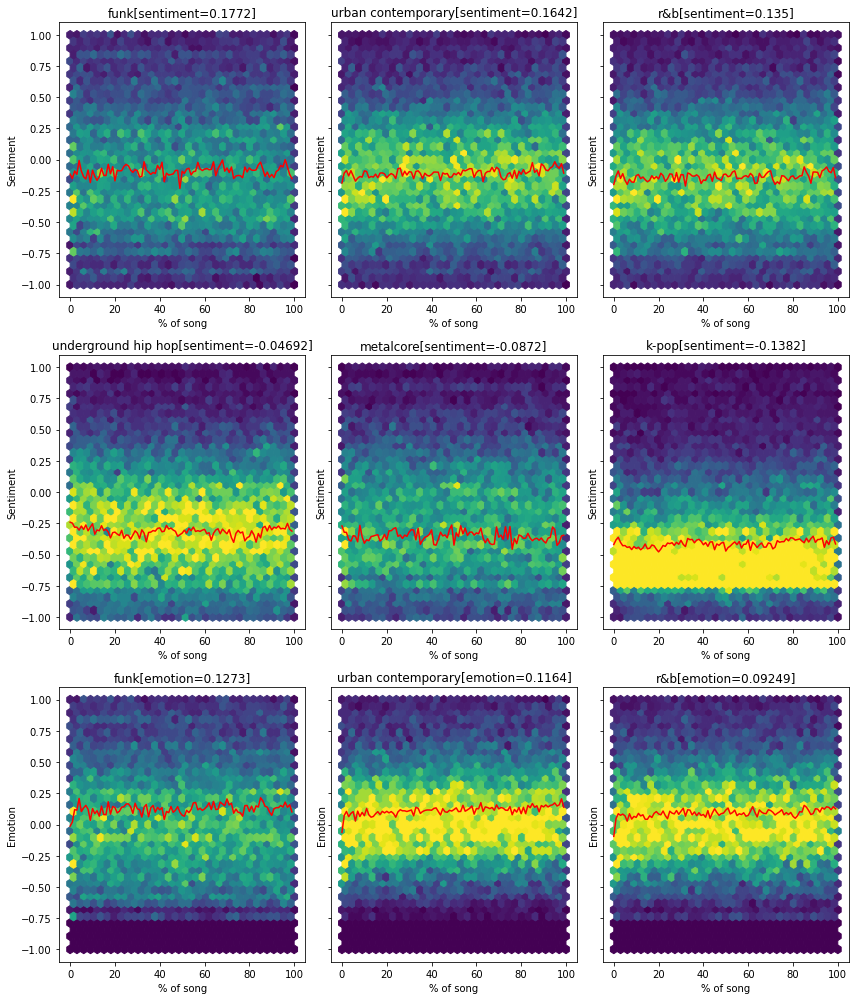

In [23]:
fig, axs = plt.subplots(3,3, figsize=(12,14),sharey='row')
most_common_sentiment = [(g,v) for (g,v) in genre_sentiment.most_common() if genre_num_songs[g] > 250]
most_common_emotion = [(g,v) for (g,v) in genre_emotion.most_common() if genre_num_songs[g] > 250]
for i,(g,v) in enumerate(most_common_sentiment[:3]):
    genre_values = np.array(genre_normalized_sentiment[g]) - mean_emotion
    Y = np.array(genre_values)
    X = np.stack([np.arange(BUCKETS) for _ in range(len(genre_values))], axis=0)
    axs[0,i].hexbin(X, Y, cmap=plt.cm.viridis, gridsize=33, extent=[0,BUCKETS,-1,1],vmin=0.0,vmax=50)
    axs[0,i].plot(np.arange(BUCKETS), np.mean(genre_values, axis=0), color="red", linewidth=1.5)
    axs[0,i].set_title(f"{g}[sentiment={v:.4g}]")
    axs[0,i].set_xlabel("% of song")
    axs[0,i].set_ylabel("Sentiment")
    
for i,(g,v) in enumerate(most_common_sentiment[-3:]):
    genre_values = np.array(genre_normalized_sentiment[g]) - mean_emotion
    Y = np.array(genre_values)
    X = np.stack([np.arange(BUCKETS) for _ in range(len(genre_values))], axis=0)
    axs[1,i].hexbin(X, Y, cmap=plt.cm.viridis, gridsize=33, extent=[0,BUCKETS,-1,1],vmin=0.0,vmax=50)
    axs[1,i].plot(np.arange(BUCKETS), np.mean(genre_values, axis=0), color="red", linewidth=1.5)
    axs[1,i].set_title(f"{g}[sentiment={v:.4g}]")
    axs[1,i].set_xlabel("% of song")
    axs[1,i].set_ylabel("Sentiment")

for i,(g,v) in enumerate(most_common_emotion[:3]):
    genre_values = np.array(genre_normalized_emotion[g]) - mean_emotion
    Y = np.array(genre_values)
    X = np.stack([np.arange(BUCKETS) for _ in range(len(genre_values))], axis=0)
    axs[2,i].hexbin(X, Y, cmap=plt.cm.viridis, gridsize=33, extent=[0,BUCKETS,-1,1],vmin=0.0,vmax=50)
    axs[2,i].plot(np.arange(BUCKETS), np.mean(genre_values, axis=0), color="red", linewidth=1.5)
    axs[2,i].set_title(f"{g}[emotion={v:.4g}]")
    axs[2,i].set_xlabel("% of song")
    axs[2,i].set_ylabel("Emotion")
    
plt.tight_layout()
plt.show()

The red line is the mean bucketed sentiment/emotion over the given genre.

## 4.3. Word Clouds and Most Relevant Words

# 5. Discussion

## 5.1. Related Artists
Spotify has their own algorithm to detect artists that "Fans Also Like" which we refer to as related artists. All artists should have 20 related artists but in rare cases, those that do not either have bugged metadata or don't have enough data yet. This can be the case for newer, more obscure artists. It is still unknown whether all links (related artists) have the same weight. One question posed is: "Is the first artist on the Fans Also Like page more related than the 20th artist on the page?"
## 5.2. Language Issue
The problem encountered was that there were many songs that were not in English. There weren't many already existing multilingual sentiment dictionaries. LabMT was chosen as it contained the most languages of what was found on the web. So any songs not existing in LabMT were skipped. About half the data had to be skipped since the language was in Danish or Swedish which is not part of LabMT. Chinese also had to be skipped despite being in LabMT due to the lack of a proper tokenizer for this language and lack of a distinction from Japanese.

A special Korean tokenizer had to be used as Korean is harder to tokenize due to the lack of spacing between words in setences. Stemming or text normalization was required to get the sentiment values. The Korean tokens were not as available in LabMT possibly due to error in tokenizing or the lack of depth in the LabMT Korean dictionary. 

The language classifier was used on the token to classify each song into a specific language. However, some songs contain multiple languages which made the classifier confused and lowered the certainty percentage.
## 5.3. Algorithmically Confoundedness
The analysis is heavily algorithmically counfounded. By definition, the dataset is not natural and is driven by engineering goals. The problem with this is that algorithmic confounding is highly invisible. This is evident in the Spotify algorithm to find related artists and the algorithm in language detection as they are both hidden to the public. Sentiment values are also calculated for each existing token in the dictionary with an algorithm. 
## 5.4. Missing and Crowdsourced Data
The LyricsGenius API "searches" for songs meaning sometimes it will get no return. This is because Genius is independent from Spotify so not all songs on Spotify are available on Genius. 

Some songs are just not represented on Genius due to the song being an instrumental. These songs will be missing from the analysis. Some genres are also just generally without lyrics.

The lyrics are crowdsourced so the quality of the lyrics highly vary. 
## 5.5 Misrepresentation of Genres/Artist
Mentioned in Project Assignment A, we originally were going to analyze the top 5 songs of each artist. However, due to the time, rate, and data constraints, we were only able to retreive the top 1 song of each artist. 

The problem this poses is that it is not fully representative of the artist. This will show bias towards pop songs as the most popular songs are usually pop. Because of this, the song's genre might not match the genre the artist is classified under. 

Another problem is that because the artist can be present in multiple genres, there can be a mismatch in the detected communities.

# 6. References

[1] Lui, Marco and Timothy Baldwin (2011) Cross-domain Feature Selection for Language Identification, In Proceedings of the Fifth International Joint Conference on Natural Language Processing (IJCNLP 2011), Chiang Mai, Thailand, pp. 553—561. Available from http://www.aclweb.org/anthology/I11-1062

[2] Dodds, Peter Sheridan, Kameron Decker Harris, Isabel M. Kloumann, Catherine A. Bliss, and Christopher M. Danforth. "Temporal patterns of happiness and information in a global social network: Hedonometrics and Twitter." PLoS ONE 6, no. 12 (2011). https://github.com/ryanjgallagher/shifterator/tree/master/shifterator/lexicons/labMT

[3] Dodds, Peter Sheridan, Eric M. Clark, Suma Desu, Morgan R. Frank, Andrew J. Reagan, Jake Ryland Williams, Lewis Mitchell et al. "Human language reveals a universal positivity bias." Proceedings of the National Academy of Sciences 112, no. 8 (2015): 2389-2394. https://github.com/ryanjgallagher/shifterator/tree/master/shifterator/lexicons/labMT

[4] Eunjeong L. Park, Sungzoon Cho. “KoNLPy: Korean natural language processing in Python”, Proceedings of the 26th Annual Conference on Human & Cognitive Language Technology, Chuncheon, Korea, Oct 2014. https://konlpy.org/en/latest/#

[5] Will Hohyon Ryu, Open Korean Text. https://github.com/open-korean-text/open-korean-text

[6] Bird, Steven, Edward Loper and Ewan Klein (2009).
Natural Language Processing with Python.  O'Reilly Media Inc. https://github.com/nltk/nltk

[7] Blondel, V.D. et al. Fast unfolding of communities in large networks. J. Stat. Mech 10008, 1-12(2008)